In [2]:
import json

from pymongo import MongoClient

import numpy as np
import matplotlib.pyplot as plt
import line_profiler

from helpers import *
from imputation import *

client = MongoClient("localhost", 27017)
db = client['usgs']
%matplotlib inline

In [ ]:
def extreme_values(y, continuity, high = True, low = True):
    n = y.size // 2
    res = y.copy()
    
    z = np.sort(np.abs(y))
    dz = z[1:] - z[:-1]
    
    if low:
        mask_min = dz[:n][::-1] > continuity
        if mask_min.sum() > 0:
            i_min = n - np.argmax(dz[:n][::-1] > continuity)
            thr_min = 0.5*(z[i_min] + z[i_min - 1])
        else:
            thr_min = z[0] - 1
    else:
        thr_min = z[0] - 1
        
    if high:
        mask_max = dz[n:] > continuity
        if mask_max.sum() > 0:
            i_max = n + np.argmax(dz[n:] > continuity)
            thr_max = 0.5*(z[i_max] + z[i_max + 1])
        else:
            thr_max = z[-1] + 1   
    else:
        thr_max = z[-1] + 1  
    
    idx = np.logical_or(res < thr_min, res > thr_max)
    return idx


def detect_spikes(y, min_amp = 0.5, thr = 0.25):
    mask = np.zeros(y.size, dtype = bool)
    for i in range(1, y.size - 1):
        dL = ( y[i] - y[i-1] ) / dt * 3600
        dR = ( y[i] - y[i+1] ) / dt * 3600 
        
        absL = abs(dL)
        absR = abs(dR)
        
        d = abs(absL - absR)
        
        if ( dL * dR > 0 ) and ( absL > min_amp ) and ( absR > min_amp ) and ( d < thr * max(absL, absR) ) :
            mask[i] = True
            
    return mask


def fix_spikes(y, mask):
    z = y.copy()
    idx = np.where(mask)[0]
    z[idx] = 0.5*(y[idx - 1] + y[idx + 1])
    return z

In [ ]:
sid = json.load(open('revision_list_d.json'))['to_review']

In [ ]:
# mis-alignment
2198000, 2422500, 2318700, 15743850

In [ ]:
good = [5124480, 2378500, 11057500, 6061500, 9447800, 2361000, 1022500, 3550000, 2329500, 11152000, 1372500, 3049000, 
        12043300, 10293000, 1193500, 9124500]

In [ ]:
e_raw = np.zeros(len(sid)) - 1
e_new = np.zeros(len(sid)) - 1

In [ ]:
si = 0
t_raw, z_raw, t_true, z_true = get_data(db, sid[si])
z_raw  = feet_to_meters(z_raw)
z_true = feet_to_meters(z_true)
dt, y_raw, y_true = align_measurements(t_raw, z_raw, t_true, z_true)
print(sid[si], dt)

In [ ]:
for si in range(len(sid)):
    try:
        t_raw, z_raw, t_true, z_true = get_data(db, sid[si])
    except:
        continue
    
    z_raw  = feet_to_meters(z_raw)
    z_true = feet_to_meters(z_true)
    dt, y_raw, y_true = align_measurements(t_raw, z_raw, t_true, z_true)
    
    if dt < 300:
        continue

    z = z_raw.copy()
    mask = extreme_values(z, continuity = 0.13, high = True, low = True)
    z[mask] = -1

    z = fill_gaps(z,  max_gap = 30 * 86400 // dt, spike_size = 2, window_size = 10)
    dt, y_new, _ = align_measurements(t_raw, z, t_true, z_true)

    y_raw  = fill_gaps(y_raw,  max_gap = 30 * 86400 // dt, spike_size = 2, window_size = 10)
    y_true = fill_gaps(y_true, max_gap = 30 * 86400 // dt, spike_size = 2, window_size = 10)
    y_new  = fill_gaps(y_new,  max_gap = 30 * 86400 // dt, spike_size = 2, window_size = 10)

    is_spike = detect_spikes(y_new, min_amp = 0.5, thr = 0.25)
    y_new = fix_spikes(y_new, is_spike)

    e_raw[si] = xae(y_raw, y_true)
    e_new[si] = xae(y_new, y_true)
    
    print(sid[si], '\t%.4f  \t%.4f' % (e_raw[si], e_new[si]))

In [ ]:
diff = e_raw - e_new
mask = np.logical_not(np.logical_or(np.isnan(e_raw), np.isnan(e_new)))
sorted(list(zip(diff[diff < 0], np.array(sid)[diff < 0])))

In [ ]:
t_raw, z_raw, t_true, z_true = get_data(db, 9418500)

z_raw  = feet_to_meters(z_raw)
z_true = feet_to_meters(z_true)
dt, y_raw, y_true = align_measurements(t_raw, z_raw, t_true, z_true)

z = z_raw.copy()
mask = extreme_values(z, continuity = 0.13, high = True, low = True)
z[mask] = -1

z = fill_gaps(z,  max_gap = 30 * 86400 // dt, spike_size = 2, window_size = 10)
dt, y_new, _ = align_measurements(t_raw, z, t_true, z_true)

y_raw  = fill_gaps(y_raw,  max_gap = 30 * 86400 // dt, spike_size = 2, window_size = 10)
y_true = fill_gaps(y_true, max_gap = 30 * 86400 // dt, spike_size = 2, window_size = 10)
y_new  = fill_gaps(y_new,  max_gap = 30 * 86400 // dt, spike_size = 2, window_size = 10)

is_spike = detect_spikes(y_new, min_amp = 0.5, thr = 0.25)
y_new = fix_spikes(y_new, is_spike)

plt.figure(figsize = (16,4))
plt.plot(y_raw, 'b-')
#plt.plot(y_true, 'g-')
plt.plot(y_new, 'r.-')
#plt.xlim(106000, 108000)

In [3]:
cursor = db['cites'].find()

X = list()
Y = list()

n = 30 * 86400 // 900

for c in cursor:
    sid = c['site_no']
    try:
        t_raw, z_raw, t_true, z_true = get_data(db, sid)
    except:
        continue
        
    z_raw  = feet_to_meters(z_raw)
    z_true = feet_to_meters(z_true)
    dt, x, y = align_measurements(t_raw, z_raw, t_true, z_true)
    
    if dt != 900:
        continue

    x = fill_gaps(x, max_gap = 30 * 86400 // dt, spike_size = 2, window_size = 10)
    y = fill_gaps(y, max_gap = 30 * 86400 // dt, spike_size = 2, window_size = 10)
    
    k = n // 2
    if k > 3:
        for i in range(0, x.size - n, k):        
            X.append(x[i:i+n])
            Y.append(y[i:i+n])

X = np.nan_to_num(np.array(X, dtype = np.float32))
Y = np.nan_to_num(np.array(Y, dtype = np.float32))

X = np.minimum(np.maximum(X, -1), 40)
Y = np.minimum(np.maximum(Y, -1), 40)

m = X.mean(1)
iqr = np.percentile(X, 95, axis = 1) - np.percentile(X, 5, axis = 1)

X = ((X.T - m) / iqr).T
Y = ((Y.T - m) / iqr).T

X = X.reshape(X.shape[0], X.shape[1], 1)

/home/dlevin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:40: RuntimeWarning: divide by zero encountered in true_divide
/home/dlevin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in true_divide
/home/dlevin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:41: RuntimeWarning: divide by zero encountered in true_divide
/home/dlevin/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in true_divide


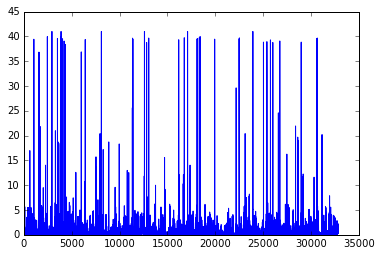

In [5]:
plt.plot(iqr)

In [7]:
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Activation, Flatten
from keras.optimizers import RMSprop, Adam
from keras.layers.pooling import MaxPooling1D, MaxPooling2D, AveragePooling1D
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Convolution1D, Convolution2D

In [ ]:
model = Sequential()

model.add(Convolution1D(nb_filter = 16, filter_length = 3, activation = 'relu', input_shape = (n, 1), init = 'lecun_uniform'))

model.add(Convolution1D(nb_filter = 32, filter_length = 5, activation = 'relu', init = 'lecun_uniform'))

model.add(Convolution1D(nb_filter = 64, filter_length = 5, activation = 'relu', init = 'lecun_uniform'))

model.add(MaxPooling1D(pool_length = 4))

model.add(Convolution1D(nb_filter = 64, filter_length = 5, activation = 'relu', init = 'lecun_uniform'))

model.add(MaxPooling1D(pool_length = 3))

model.add(Flatten())

model.add(Dense(n // 4, activation = 'relu'))

model.add(Dense(n, activation = 'linear'))

opt = Adam(lr = 1e-3)
model.compile(optimizer = opt, loss = 'mse')

In [65]:
n = 1024
N = 1000
t = np.linspace(-np.pi, np.pi, n)

X = np.zeros((N, n, 1))
Y = np.zeros((N, n))

for i in range(N):
    c = 1 - 2*np.random.rand()
    A = 1 + 2*np.random.rand()
    w = 2*np.random.rand()
    phi = 3 - 6*np.random.rand()
    sigma = 0.05   
    
    y = c + A*np.sin(w*t + phi) + sigma*np.random.randn(n)
    x = y.copy()
    
    j = np.random.randint(0, n//2 - 1)
    k = np.random.randint(0, n//3 - 1)
    a = 2*x.max() + np.random.randn()
    b = a + np.random.randn()
    x[j:j+k] += np.linspace(a, b, k) 
    
    idx = np.random.choice(np.arange(n), 16, replace = False)
    x[idx] += 2*x.max() + np.random.randn(idx.size)
    
    X[i, :, 0] = x
    Y[i, :] = y

In [72]:
model = Sequential()

model.add(LSTM(output_dim = 16, return_sequences = False, activation = 'tanh', input_shape = (1024, 1)))
model.add(Dense(n, activation = 'linear'))
opt = Adam(lr = 1e-2)
model.compile(optimizer = 'adam', loss = 'mse')

In [73]:
model.fit(X, Y, 
          nb_epoch = 100, 
          verbose = 2, 
          validation_split = 0.5,
          batch_size = 100)

INFO (theano.gof.compilelock): Refreshing lock /home/dlevin/.theano/compiledir_Linux-3.19--generic-x86_64-with-debian-jessie-sid-x86_64-3.5.2-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /home/dlevin/.theano/compiledir_Linux-3.19--generic-x86_64-with-debian-jessie-sid-x86_64-3.5.2-64/lock_dir/lock


Train on 500 samples, validate on 500 samples
Epoch 1/100
4s - loss: 2.5178 - val_loss: 2.5217
Epoch 2/100
4s - loss: 2.5058 - val_loss: 2.5093
Epoch 3/100
4s - loss: 2.4939 - val_loss: 2.4964
Epoch 4/100
4s - loss: 2.4814 - val_loss: 2.4833
Epoch 5/100
4s - loss: 2.4684 - val_loss: 2.4696
Epoch 6/100
4s - loss: 2.4555 - val_loss: 2.4554
Epoch 7/100
4s - loss: 2.4413 - val_loss: 2.4408
Epoch 8/100
4s - loss: 2.4273 - val_loss: 2.4258
Epoch 9/100
4s - loss: 2.4136 - val_loss: 2.4103
Epoch 10/100
4s - loss: 2.3980 - val_loss: 2.3950
Epoch 11/100
4s - loss: 2.3844 - val_loss: 2.3787
Epoch 12/100
4s - loss: 2.3685 - val_loss: 2.3620
Epoch 13/100
4s - loss: 2.3533 - val_loss: 2.3451
Epoch 14/100
4s - loss: 2.3363 - val_loss: 2.3268
Epoch 15/100
4s - loss: 2.3214 - val_loss: 2.3095
Epoch 16/100
4s - loss: 2.3068 - val_loss: 2.2948
Epoch 17/100
4s - loss: 2.2920 - val_loss: 2.2813
Epoch 18/100
4s - loss: 2.2798 - val_loss: 2.2650
Epoch 19/100
4s - loss: 2.2660 - val_loss: 2.2497
Epoch 20/100


In [74]:
y_pred = model.predict(X)

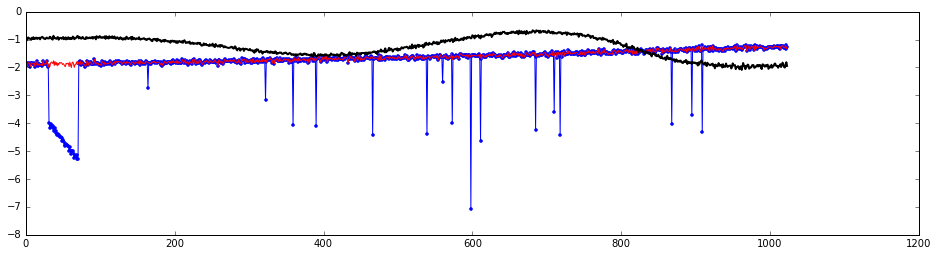

In [122]:
i = np.random.randint(500, 1000)
plt.figure(figsize = (16,4))
plt.plot(X[i],  'b.-')
plt.plot(Y[i],  'r-')
plt.plot(y_pred[i], 'k-', lw = 2)